# Metalearned Neural Memory with local memory updates

In [12]:
import math, copy, sys, logging, json, time, random, os, string, pickle, re

import torch
import torch.optim as optim
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F

from sklearn.metrics import accuracy_score
import numpy as np
import matplotlib.pyplot as plt

from modules.Vocabulary import Vocab
from modules.LoadTrainSave import save_model, load_model, Teacher
from modules.TransformerComponents import Transformer

%matplotlib inline
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# MNMp -The Memory Controller 

Imagine that an LSTM is the agent. LSTMs takes in a current state x_t, the previous hidden state h_t-1 and output the current hidden state h_t

Now imagine that our LSTM has a storage center for memory besides h_t, the 
`neural memory network` (NMN), and at each step it receives a current state x_t, the previous hidden state h_t-1 and a read out from the NMN v_t-1. 

Each x_t has shape (batch size, n_units), each readout vector v_t-1 has shape `(batch size, self.n_in_mem)`

Since the LSTM is initialized `torch.nn.LSTMCell(input_size, hidden_size, bias=True)` We concatenate the input x_t with the memory readout vector v_t-1

`self.lstm_l1 = nn.LSTMCell(n_units + n_in_mem, n_units)`

In the paper this LSTM controller is 

$$h_t = LSTM(x_t, v^{r}_{t-1}, h_{t-1})$$

The first time that the MNMp forward pass is used, the initial memory readout vector - self.v, and LSTM controller hidden states - self.h_lstm and self.c_lstm is initialized as zero vectors, it is then updated thereafter with each subsequent forward pass x_t.

In PyTorch the LSTMCell takes an input and a hidden state (hidden state, cell state) tuple, so this mathematical term appears as 

`self.h_lstm, self.c_lstm = self.lstm_l1(torch.cat([x, self.v], dim=1), (self.h_lstm, self.c_lstm))`

The hidden state output of the LSTM controller is placed through an affine transformation and tanh non-linearity to produce a large vector that is then separated into the interaction vectors.

$$[k^{r}_{t,1} . . . k^{r}_{t,H}; k^{w}_{t,1} . . .  k^{w}_{t,H}; v^{w}_{t,1}. . . v^{w}_{t,H}; B_{t}] = tanh(W_v h_t + b_v)$$

`int_vecs = torch.tanh(self.heads_l2(self.h_lstm))`

These interaction terms contain value vectors to write to memory, key vectors that if seen again in the future are meant to retreive these memorized values, and also key vectors to retreive memorys for immediate use.

Leaveing out the number of heads, each step of the LSTM agent generates two keys and one value. A read key to retreive memory, and a write key and write value to store memory.

For each sample in the batch, there are H sets of 3 vectors, the read key, write key and write value, plus one rate vector beta_.  


A new read value is read from the memory function using the read key in the `v_r = self.memfunc.read(k_r)` step. 

The rate vector is projected to a scalar "rate", called beta in the range 0 to 1. The operation

`n_k_v = n_k_v.view(n_k_v.shape[0], self.n_heads, -1).contiguous()`

The rate vector is separated from the other interaction vectors in this step, 
this portion of the interaction vectors n_k_v consists of the write key-value pairs,
and the read key. 

`beta_, n_k_v = torch.split(int_vecs,[self.dim_hidden,self.dim_hidden*self.n_heads*3],dim=1)`

The shape of the n_k_v undergoes these shape changes 

(batchsize, dim_hidden*n_heads*3)->(batchsize,n_heads,dim_hidden*3)

`n_k_v = n_k_v.view(n_k_v.shape[0], self.n_heads, -1).contiguous()`
        
`k_w, v_w, k_r = torch.chunk(n_k_v, 3, dim=2)`

Now each of these tensors k_w, v_w, k_r is of shape (batchsize, n_heads, dim_hidden)

k_w, v_w are passed to the memory update function along with the rate scalar beta. How the Memory is updated is explained in the FFMemory section

`re_const_loss, re_const_loss_init = self.memfunc.update(k_w, v_w, beta_rate=beta)`

The controller hidden state is updated using both the previous hidden state and the read value produced from the memory

`h_lstm = self.read_out(torch.cat([self.h_lstm, self.v_r], dim=1))`

In [5]:
class MNMp(nn.Module):

    def __init__(self, dim_hidden, n_heads = 4):
        
        """ dim_hidden is the hidden size of the LSTM controller,
            the Memory Network, and the interaction vectors
            n_heads is the number of interaction heads """

        super(MNMp, self).__init__()
        
        self.dim_hidden = dim_hidden
        self.n_heads = n_heads
        
        self.control = nn.LSTMCell(dim_hidden*2, dim_hidden)
        
        dim_concat_interact = dim_hidden*n_heads*3 + dim_hidden
        self.interaction = nn.Linear(dim_hidden, dim_concat_interact)
        self.memfunc = FFMemoryLearned(dim_hidden)
        self.kv_rate = nn.Linear(dim_hidden, 1)
        self.read_out = nn.Linear(dim_hidden+dim_hidden, dim_hidden)
        
        self.v_r = torch.nn.Parameter(torch.zeros((1, self.dim_hidden)))
        self.h_lstm = torch.nn.Parameter(torch.zeros((1, self.dim_hidden)))
        self.c_lstm = torch.nn.Parameter(torch.zeros((1, self.dim_hidden)))
        
    def repeat_v_h_c(self, batch_size):

            v_r = self.v_r.repeat(batch_size,1)
            h_lstm = self.h_lstm.repeat(batch_size,1)
            c_lstm = self.c_lstm.repeat(batch_size,1)
            
            if next(self.parameters()).is_cuda:
                self.v_r = self.v_r.cuda()
                self.h_lstm = self.h_lstm.cuda()
                self.c_lstm = self.c_lstm.cuda()
                                         
            return v_r, h_lstm, c_lstm
            
    def forward(self, context_vector):
        
        """ the input context_vector must have shape (batch_size, emb_dim) because it will be 
        concatenated with self.v_r of the same shape """

        v_r, h_lstm, c_lstm = self.repeat_v_h_c(context_vector.shape[0])
        
        context_vector = context_vector.squeeze(1) # (batch_size, 1, emb_dim) -> (batch_size, 1, emb_dim)
        
        # combine the current state x with the previous memory v_r, hidden and cell states
        h_lstm, c_lstm = self.control(torch.cat([context_vector, v_r], dim=1), (h_lstm, c_lstm))
        
        int_vecs = torch.tanh(self.interaction(h_lstm))
        
        beta_, n_k_v = torch.split(int_vecs, 
                                   [self.dim_hidden,self.dim_hidden*self.n_heads*3],
                                   dim=1)  
        
        beta = torch.sigmoid(self.kv_rate(beta_)) #beta shape (batch_size,1)
        
        n_k_v = n_k_v.view(n_k_v.shape[0], self.n_heads, -1).contiguous()
        
        # Separate out our 3 interaction terms 
        k_w, v_w, k_r = torch.chunk(n_k_v, 3, dim=2)
        
        # use the first 2 terms to bind the write keya nd write value
        reconst_loss, reconst_loss_init = self.memfunc.update(k_w, v_w, beta_rate=beta)
        
        # use the last term to retreive memory 
        v_r = self.memfunc.read(k_r)
        
        # combine the retreived memory with the hidden state into the context vector
        context_vector = self.read_out(torch.cat([h_lstm, v_r], dim=1))

        return context_vector.unsqueeze(1), reconst_loss, reconst_loss_init

## Perceptron Learning Rule

The perceptron learning rule is used to do fast gradient free updates to the neural memory network. This perceptron learning rule is explained well here: http://hagan.okstate.edu/4_Perceptron.pdf 

The perceptron learning rule allows you to change the weights of a linear transformation matrix in such a way as to nudge it's output closer to or away from a desired target or vector of targets, without having to calculate a mean squared error, and perform backpropagation. 

Consider the some layer of a feed forward neural network, activations "a" = relu(Wx+b).

"a" might have several dimensions, but the first dimension of "a" is only dependant on x and the first row of W. So if you consider W to be a single row and "a" to be a single activation, then without loss of generality, what applies for this row applies to the entire matrix W and the entire vector a. 

if `W = [-1, 1]` and `b = [-1]`, you can see by plotting `W[x_1, x_2] + b = 0` on a horizontal `x_1` by vertical `x_2` axis that this is a line with slope `1` that intersects the `x_1` axis at `-1`. 

<img src = 'files/grapher1.gif' width=400 height =400>

This is the decision boundary because at this boundary `Wx+b=0` and on either side of the boundary you are either positive or negative.  The point `p1 = x_1, x_2 = 2, 1` would be evaluated as `-2` if you plugged it into `Wx+b` and so would be zero after an activation function `f(a) = max(0,a)`. You can tell which side of the line above is the negative and positive regime by seeing which direction the vector `[-1, 1]` points. Moving `-1` along `x_1` means one step to the left, and `1` step upwards along `x_2` draws an arrow that point up and to the left. So it seems the point `[2,1]` is on the wrong side of this line if you want it to be positive. That direction that vector `W` points in, is the direction towards the side of the decision boundary that is positive in `Wx`. The opposite side of the boundary is negative in `Wx`. 

Suppose without calculating the gradient you want to change `W` such that the point `p1 = x_1, x_2 = 2, 1` will be classified as positive. if you add `p1` to `W` you get `W = [1, 2]`, and if you add the error to the bias, ie `error = target - activation = 1 - 0 = 1`, you get `error + b_old = -1 + 1 = b_new = 0`

<img src = 'files/grapher2.gif' width=400 height =400>

The new line points up and to the right and will now classify p1 correctly. `Wx + b = 2+2+1 = 5`. Notice that b also changes in the correct direction, if you didnt change b, the resulting decision boundary `[1, 2]x - 1 = 0` would have been a negatively sloped line that intersects the `x_1` axis at `x_1 = 1`, whereas now that `b = 1`, the intersect is at `0`. This update has not only rotated the vector `W` to point towards `p1` but shifted the decision boundary downwards pulling the boundary away from `p1` so that `p1` is farther within the region of positivity and therefore more positive.

The perceptron learning rule formula is as follows:

$$ W_t := W_{t-1} + (target - activation) \otimes input^{T} $$

$$ b_t = b_{t-1} + (target - activation) $$

`t` is the update iteration timestep. The circle with an x inside is the outer product, this fits with the shape of W since if the activation is m-dimensional, and input is n-dimensional, the W is shape mxn and the bias is shape mx1. Therefore the the update to W must be the same shape as W which is the shape you would get if you performed an outer product between (target - activation) x (input^T) = (update) which has shape (mx1)(1xn) = (mxn)

 In our example (target - activation) x (input^T) = (1 - 0) x `[[2],[1]]^T` = `[2,1]`

For us the target vector is not some kind of supervised label, instead it is a target that the `backward feedback prediction functions (BFPF)` learns to come up with the target activations `z'` for all the layers of the `neural memory network` (NMN) in such a way as to be the target int he update rule to bind the vector to vector mapping of key value pairs.

Our memory is stored in a multi-layer feed forward NMN

$$ v^{r}_{t,i} = {NMN}(k^{r}_{t,i})$$

$$ z'^{l} = {BFPF}^{l}(v^{w}_{}t) $$

v^w is the memorywe want to remember, ie write to memory. k^r is the thought that occurs in real time that prompts us to retrieve v^r. 

v^r is the retreived memory for timestep t and i-th head, i-th because there might be several memories we want to retreive, t because we might be performing this retrieval for each step in a task.

Lets re-write the above perceptron rule in a format that is analoguous to the layer by layer update rule in [Metalearned Neural Memory](https://arxiv.org/abs/1907.09720)

$$ W_t := W_{t-1} - (activation - target) \otimes x^{T} $$

M^l is the weight matrix for layer l of the NMN, t is the new matrix after update, t-1 is the old matrix before update, B is a learning rate, z^l is the current activation for layer l prior to update, z'^l is the target activation for layer l. z^{l-1} are activations of the previous layer

$$ M^{l}_{t} :=  M^{l}_{t-1} - B^{l}_{t}(z^{l} - z'^{l}) {z^{l-1}}^{T} $$

These concepts are reflected in `class FFMemoryLearned(nn.Module):`

In [130]:
class FFMemoryLearned(nn.Module):
    
    '''
    This is a minimal 3 layer feed forward neural net with
    methods for meta-learned, aka, fast local updates
    '''
    
    def __init__(self, dim_hidden):
        
        super(FFMemoryLearned, self).__init__()
        
        # In the future you can use the get_clones function in TransformerComponents
        # that uses the nn.ModuleList object to make several copies of the 
        self.l1 = nn.Linear(dim_hidden, dim_hidden).weight.data
        self.l2 = nn.Linear(dim_hidden, dim_hidden).weight.data
        self.l3 = nn.Linear(dim_hidden, dim_hidden).weight.data
        
        self.Ws = [self.l1, self.l2, self.l3]
        self.Ws_temp = None
        
        # the 3 in  3*dim_hidden just reflects the fact that we define 3 layers above
        self.expected_activation = nn.Linear(dim_hidden, 3*dim_hidden)

    def if_cuda(self):
        
        if next(self.parameters()).is_cuda:
            self.l1 = self.l1.cuda()
            self.l2 = self.l2.cuda()
            self.l3 = self.l3.cuda()
            
        self.Ws = [self.l1, self.l2, self.l3]

    def detach_mem(self):
        
        for W_l in self.Ws:
            
            W_l.detach()
            
        self.Ws_temp = None

    def forward(self, key):
        
        '''
        The forward pass through the neural memory network (NMN).
        This is used both in the read and write (update) 
        
        Input:
            key - type (torch.Tensor) shape (batch_size, num_heads, dim_hidden): 
                this is either the read_key or write_key input to the NMN
        Output:
            value - (torch.Tensor) shape (batch_size, num_heads, dim_hidden):
                the output, aka last layer activation, from the NMN 
            activations - (list) of length (num layers - 1): 
                the layer activations, except the last one, in an ordered list
                each of shape [batch_size, num_heads, dim_hidden])
        '''
        
        self.if_cuda()
        
        # is reset at beginning of every new sequence 
        # If self.Ws_temp is not None, thats because we have just done a batched update
        # and self.Ws_temp has a matrix for each batch sample 
        if self.Ws_temp is None: 
            
          self.Ws_temp = []
        
          for W_l in self.Ws:
                
            # replicate weights of each layer across each batch sample
            # (emb_dim, emb_dim) -> (batch_size, emb_dim, emb_dim)
            
            W = W_l.unsqueeze(dim=0).expand((key.shape[0], W_l.shape[0], W_l.shape[1]))

            self.Ws_temp.append(W)
            
        activations = [] # hidden activations except the last  
        
        a = key
        
        for W_l in self.Ws_temp[:-1]:

            a = torch.matmul(a, W_l.transpose(1,2))
            a = torch.sigmoid(a)
            activations.append(a)
        
        value = torch.matmul(a, self.Ws_temp[-1].transpose(1,2))

        return value, activations

    def mse_loss(self, y_pred, y):
        'mean squared error'
        
        diff = y_pred - y
        diff = diff.view(-1)
        mse = diff.dot(diff)/diff.size()[0]
        
        return mse

    def read(self, k, weights=None, avg=True):
        'read from memory'
        
        v, h_acts = self.forward(k)

        if weights is not None:
          v *= weights
        if avg:
          v = v.mean(dim=1)
        
        return v

    def update(self, k_w, v_w, beta_rate=0.1):  
        
        '''
        The forward function is run twice, once before and once after the local update
        k_w, v_w - shape [batch_size, num_heads, dim_hidden]
        
        '''

        v_w_approx, activations = self.forward(k_w)
        
        v_w_approx = v_w_approx.contiguous()
        v_w = v_w.contiguous()
        
        # before local update, see how well the this key and value are already bound
        reconst_loss_init=self.mse_loss(v_w_approx.view(-1,v_w_approx.shape[2]),v_w.view(-1,v_w.shape[2]))
        
        # backward feedback prediction functions predict the expected activations of each NMN layer
        # v_w.view(-1, v_w.shape[2]) performs shape change 
        # [batch_size, num_heads, emb_dim] -> [batch_size*num_heads, emb_dim]

        # z_pr is the target activations for each layer
        z_pr = self.expected_activation(v_w.view(-1, v_w.shape[2]))
        # output z_pr is of shape [batch_size*num_heads, emb_dim*num_layers]
        z_pr = z_pr.view(v_w.shape[0], v_w.shape[1], -1)
        # output z_pr is of shape [batch_size, num_heads, emb_dim*num_layers]
        z_pr = torch.chunk(z_pr, 3, dim=2) # result is a tuple of length 3
        # each element in z_pr is shape [batch_size, num_heads, emb_dim]
        
        if len(beta_rate.shape) < 3:
            beta_rate = beta_rate.unsqueeze(1)

        # z2 and z1 are offset by 1
        z2 = activations + [v_w_approx] # z2 are the initial output activations of the 3 layers
        z1 = [k_w] + activations # z2 are the initial input activations of the 3 layers
        
        # Ws_t is a list of the updated weights of the NMN 
        Ws_t = []
        
        # iterates through the 4 lists in reverse order as x_, applying the perceptron learning rule 
        # diff id shape (batchsize, heads, dim_hidden)
        for W_l, z2_, z1_, z_pr in reversed(list(zip(self.Ws_temp, z2, z1, z_pr))):
            
            z1_ = z1_*beta_rate.expand(z1_.shape) #
            diff = z2_ - z_pr # activation minus target_activation 
            diff = diff*(2./(diff.shape[1]*diff.shape[2])) # re-normalize diff, why? 
            W_l = W_l - torch.matmul(diff.transpose(1,2), z1_) #-0.0001*W_l 0.1
            Ws_t.insert(0, W_l)

        self.Ws_temp[:] = Ws_t
        
        # Run memory forward again after memory update to see how well
        # the v_w has been reconstructed as v_w_approx, use mse to
        # quantify the quality of the key value binding as the reconst_loss
        
        v_w_approx, activations = self.forward(k_w)
        
        reconst_loss = self.mse_loss(v_w_approx.view(-1, v_w_approx.shape[2]), v_w.view(-1, v_w.shape[2]))
        
        return reconst_loss, reconst_loss_init

The dot product increases as the dimensions get larger. A fix is to introduce a scaling factor, and was proposed in Transformers [Attention Is All You Need](https://arxiv.org/abs/1706.03762). This function also has no learnable parameters. Above we scale down diff in proportion to the number of heads and number of hidden dimensions so that when we perform the matrix multiply with the previous activations, this dot product does not blow up

In [131]:
class Bot(nn.Module):
    
    def __init__(self, emb_dim, n_layers, heads, dropout, vocab):
        
        super().__init__()
        
        self.emb_dim = emb_dim
        
        self.vocab = vocab
        self.sos_tok = torch.LongTensor([[self.vocab.word2index["<SOS>"]]]) 
        self.eos_tok = torch.LongTensor([[self.vocab.word2index["<EOS>"]]]) 
        
        self.encodeInput = Transformer(emb_dim, n_layers, heads, dropout)
        self.encodeEncoding = Transformer(emb_dim, n_layers, heads, dropout)
        self.decodeEncoding = Transformer(emb_dim, n_layers, heads, dropout)

        self.mnm = MNMp(emb_dim, heads)
        
        self.context_vec = None
        
    def memory_utils(self, batch_size):

        if self.context_vec is None:
            cntxt_seq_len = 1
            self.context_vec = torch.randn(batch_size, cntxt_seq_len, self.emb_dim)
            
        if self.context_vec.shape[0] > batch_size:
            self.context_vec = self.context_vec[0,:,:]
            
        if self.context_vec.shape[0] < batch_size:
            self.context_vec = self.context_vec[0,:,:].repeat(batch_size, 1, 1)
    
        self.context_vec = self.context_vec.detach()
        self.mnm.memfunc.detach_mem()
        
    def forward(self, in_toks, in_mask, out_toks, out_mask):
        
        self.memory_utils(batch_size = in_toks.shape[0])
        
        in_vecs = self.vocab.embedding(in_toks)
        out_vec = self.vocab.embedding(out_toks)

        self.context_vec, rcl, rcli = self.mnm(self.context_vec)
        encin_vec = self.encodeInput(in_vecs, in_mask, self.context_vec, None)
        self.context_vec = self.encodeEncoding(self.context_vec, None, encin_vec, None)
        
        dout = self.decodeEncoding(out_vec, out_mask, encin_vec, in_mask)
        
        return dout, rcl, rcli
    
    def teacher_forcing(self, src, trg):
        
        self.train()
        trg_start = torch.cat((self.sos_tok.repeat(trg.shape[0],1), trg),dim=1)
        trg_end = torch.cat((trg, self.eos_tok.repeat(trg.shape[0],1)),dim=1)
        src_mask = (src != self.vocab.word2index["<PAD>"]).unsqueeze(-2)
        trg_mask = (trg_end != self.vocab.word2index["<PAD>"]).unsqueeze(-2)
        
        seq_len = trg_start.size(1) 
        np_mask = np.triu(np.ones((1,seq_len,seq_len)),k=1).astype('uint8')
        np_mask =  torch.from_numpy(np_mask) == 0
        
        if trg.is_cuda:
            np_mask = np_mask.cuda()
            
        trg_mask = trg_mask & np_mask
        
        out_vecs, rcl, rcli = self.forward(src, src_mask, trg_start, trg_mask)
        
        return out_vecs, trg_end, rcl, rcli
    
    def string2string(self, input_string, maxlen = 20):
        
        self.eval()
        in_toks = self.vocab.string2tensor(input_string)
        in_vecs = self.vocab.embedding(in_toks)
        
        self.memory_utils(batch_size=in_toks.shape[0])
        
        self.context_vec, rcl, rcli = self.mnm(self.context_vec)
        encin_vec = self.encodeInput(in_vecs, None, self.context_vec, None)
        self.context_vec = self.encodeEncoding(self.context_vec, None, encin_vec, None)
        
        decode_toks = self.sos_tok
        
        for pos in range(maxlen):
            
            decode_vecs = self.vocab.embedding(decode_toks)
            dout = self.decodeEncoding(decode_vecs, None, encin_vec, None)
            vocabdist = self.vocab.emb2vocab(dout)
            next_toks = torch.argmax(vocabdist, dim=2)
            decode_toks = torch.cat((decode_toks, next_toks[:,-1].unsqueeze(0)), dim=1) 
            
            if next_toks[:,-1] == self.eos_tok.squeeze(0):
                
                toks = decode_toks[0][1:-1].data.cpu().numpy()
                de_str = ' '.join([self.vocab.index2word[int(tok)] for tok in toks])

                return de_str
            
        toks = decode_toks[0].data.cpu().numpy()
        de_str = ' '.join([self.vocab.index2word[tok] for tok in toks])
        
        return de_str

In [132]:
emb_dim, n_layers, heads, dropout = 8, 3, 5, 0.05

vocab = Vocab(emb_dim)
model = Bot(emb_dim, n_layers, heads, dropout, vocab)
teacher = Teacher(model.vocab)

print(model.vocab.word2index)

{'<PAD>': 0, '<SOS>': 1, '<EOS>': 2, '<UNK>': 3, 'my': 4, 'name': 5, 'is': 6, ',': 7, 'hi': 8, '.': 9, 'what': 10, '?': 11, 'its': 12}


torch.Size([2, 5, 8])
torch.Size([2, 5, 8])
mean accuracy 0.0 celoss 9.2065 rcloss 1.199647 d_rcloss 0.0231 training progress 0.0 learning rate [0.01]


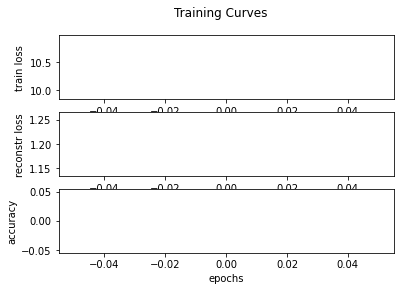

In [133]:
total_batches = 1
best_acc = 0
lamda = 8
batch_size = 2
learning_rate = 0.01 

optimizer=torch.optim.Adam(model.parameters(),lr=learning_rate,betas=(0.9, 0.98),eps=1e-9)
scheduler=torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer,'min',factor=0.99,patience=100)

loss_all_list = []
rcloss_all_list = []
accuracy_list = []

for batch in range(total_batches):
    
    #print('remember info')
    
    intro, introtarget, whatmyname, yournameis = teacher.get_batch(batch_size)
    
    out_vecs, trg_end, rcl, rcli = model.teacher_forcing(intro, introtarget)
    
    vocab_logits = model.vocab.emb2vocab(out_vecs)
    
    predictions = vocab_logits.view(-1, vocab_logits.size(-1))
    
    target = trg_end.view(-1)

    batch_loss = F.cross_entropy(predictions, target, 
                                 ignore_index = model.vocab.word2index["<PAD>"])

    reconstruction_loss = lamda*rcl
    
    ################# Next Part of Conversation ########################
    
    #print('retreive memory')
    
    out_vecs, trg_end, rcl, rcli = model.teacher_forcing(whatmyname, yournameis)
    
    vocab_logits = model.vocab.emb2vocab(out_vecs)

    predictions = vocab_logits.view(-1, vocab_logits.size(-1))
    
    target = trg_end.view(-1)
    
    acc = accuracy_score(target, torch.argmax(predictions, dim=1))

    batch_loss += F.cross_entropy(predictions, target, 
                                 ignore_index = model.vocab.word2index["<PAD>"])
    
    reconstruction_loss += lamda*rcl
    conversation_loss = batch_loss + reconstruction_loss
    
    scheduler.step(conversation_loss)
    optimizer.zero_grad()
    conversation_loss.backward()
    torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
    optimizer.step()
    
    if batch % int(total_batches/20 + 1) == 0:
        
        loss_all_list.append(conversation_loss.float().item())
        rcloss_all_list.append(reconstruction_loss.float().item())
        accuracy_list.append(acc)
        mean_accuracy = np.mean(accuracy_list[-10:])

        if mean_accuracy > best_acc:
            print('New Best...')
            best_acc = mean_accuracy
            
            
        print("mean accuracy", round(mean_accuracy,4), 
              "celoss", round(batch_loss.float().item(),4), 
              "rcloss", round(reconstruction_loss.float().item(),6), 
              "d_rcloss", round((rcli - rcl).float().item(),4),
              "training progress", round(batch/total_batches,4),
              "learning rate", scheduler._last_lr)
            
        if mean_accuracy > 0.96:
            break

fig, (ax1, ax2, ax3) = plt.subplots(3)
fig.suptitle('Training Curves')
ax1.set(xlabel='epochs', ylabel='train loss')
ax2.set(xlabel='epochs', ylabel='reconstr loss')
ax3.set(xlabel='epochs', ylabel='accuracy')
ax1.plot(loss_all_list, label='train loss')
ax2.plot(rcloss_all_list, label='reconstrunction loss')
ax3.plot(accuracy_list, label='accuracy')

In [138]:
number_list = [1, 2, 3]
str_list = ['one', 'two', 'three']

# Two iterables are passed
result = zip(number_list, str_list)

# Converting iterator to set

for tup in reversed(list(result)):
    print(tup)

(3, 'three')
(2, 'two')
(1, 'one')
